In [1]:
import pandas as pd
import numpy as np
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
import matplotlib.pyplot as plt
import C14preproc as prep
import C14utils
from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset
from scipy.interpolate import interp1d
import isamcalc_lib as isam
import os.path
import uq_lib as uq
import SOCtools as soc
from os import path
from IPython.display import display


In [2]:
# Create dictionaries
site = {
    "43"  : 0,
    "110" : 1,
    "143" : 2,
    "197" : 3,
    "146" : 4,   
}

yr_dict = {
    "43"  : 2001,
    "110" : 2005,
    "143" : 2007,
    "197" : 1999,
    "146" : 2002,   
}

sen_exp = {
    "aa_u"      : 0,    # high 
    "aa_l"      : 1,    # low
    "bb_u"      : 2,
    "bb_l"      : 3,
    "bd_u"      : 4,
    "bd_l"      : 5,
    #"control"   : 6,
    "d_u"       : 7,
    "d_l"       : 8,
    "dep_u"     : 9,
    "dep_l"     : 10,
    "control"   : 11,
    "q_u"       : 12,
    "q_l"       : 13,
    "s_u"       : 14,
    "s_l"       : 15,
    "gamma_u"   : 16,
    "gamma_l"   : 17,
}

In [28]:
#=============================================================
# Obtain the results of sensitivity test for each parameters
#=============================================================

# Read in model output from the sensitivity test cases
#initialize
soccm_test = [None] * 5
d14cm_test = [None] * 5
bulk_d14c_topsoil = np.zeros((18, 5))
tau_topsoil = np.zeros((18, 5))
bulk_d14c_subsoil = np.zeros((18, 5))
tau_subsoil = np.zeros((18, 5))

# Calculate tau for each case
for siteid, ind in site.items():
    # Read in D14C of the ISAM model output
    fname = 'isam_dc14_'+str(siteid)+'sen.dat'
    d14cm_test[ind] = pd.read_table(fname, header=None, delimiter=r"\s+")
    d14cm_test[ind].columns = ['ID', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10']
    d14cm_test[ind] = d14cm_test[ind].set_index('ID')
    # Read in SOC
    fname = 'isam_soc_'+str(siteid)+'sen.dat'
    soccm_test[ind] = pd.read_table(fname, header=None, delimiter=r"\s+")
    soccm_test[ind].columns = ['ID', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10']
    soccm_test[ind] = soccm_test[ind].set_index('ID')

    # Weighted C14 for topsoil and subsoil separatedly
    # Totally 18 cases for each site
    sampleyr = yr_dict[str(siteid)] * np.ones(len(d14cm_test[ind]))
    for i in np.arange(0,18):
        bulk_d14c_topsoil[i,ind] = isam.avg_wt_topsoil(soccm_test[ind].as_matrix()[i,], d14cm_test[ind].as_matrix()[i,])
        bulk_d14c_subsoil[i,ind] = isam.avg_wt_subsoil(soccm_test[ind].as_matrix()[i,], d14cm_test[ind].as_matrix()[i,])

    # Calculate the turnover time
    tau, cost = C14utils.cal_tau(bulk_d14c_topsoil[:,ind], sampleyr, 1, 0)
    tau_topsoil[:, ind] = tau[:,0]
    tau, cost = C14utils.cal_tau(bulk_d14c_subsoil[:,ind], sampleyr, 1, 0)
    tau_subsoil[:, ind] = tau[:,0]

## Initialize record variables
## Records for all sites
# Results for control run
con_topsoil = np.zeros((3, 5))
con_subsoil = np.zeros((3, 5))
# Results for uncertainty runs
sen_topsoil = np.zeros((32, 5))
sen_subsoil = np.zeros((32, 5))
# Uncertainty range
rg_topsoil = np.zeros((24, 5))
rg_subsoil = np.zeros((24, 5))

## Temporary records for one site
# Store the case diff of SOC and TT from the control run
tmp_topsoil = []
tmp_subsoil = []
# Temporary array to store the case SOC and TT value
me_topsoil = []
me_subsoil = []

# Calculate the sensitivity range of SOC, D14C and tau
for siteid, ind in site.items():   
    # top soil is the first 5 layer
    # subsoil is the 6th, 7th and part of 8th soil layer (30% depth)
    
    ## Case: aa
    # Get idxs
    idx_u = sen_exp.get("aa_u")
    idx_l = sen_exp.get("aa_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: bb
    idx_u = sen_exp.get("bb_u")
    idx_l = sen_exp.get("bb_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())    
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: bd
    idx_u = sen_exp.get("bd_u")
    idx_l = sen_exp.get("bd_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    # control
    idx = sen_exp.get("control")
    con_topsoil[0,ind] = isam.agg_topsoil(soccm_test[ind].as_matrix()[idx,:])
    con_subsoil[0,ind] = isam.agg_subsoil(soccm_test[ind].as_matrix()[idx,:])
    con_topsoil[1,ind] = isam.avg_wt_topsoil(soccm_test[ind].as_matrix()[idx,:], d14cm_test[ind].as_matrix()[idx,:])
    con_subsoil[1,ind] = isam.avg_wt_subsoil(soccm_test[ind].as_matrix()[idx,:], d14cm_test[ind].as_matrix()[idx,:])
    con_topsoil[2,ind] = tau_topsoil[idx, ind]
    con_subsoil[2,ind] = tau_subsoil[idx, ind]
    
    ## Case: d
    idx_u = sen_exp.get("d_u")
    idx_l = sen_exp.get("d_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: dep
    idx_u = sen_exp.get("dep_u")
    idx_l = sen_exp.get("dep_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: q 
    idx_u = sen_exp.get("q_u")
    idx_l = sen_exp.get("q_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: s
    idx_u = sen_exp.get("s_u")
    idx_l = sen_exp.get("s_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: gamma
    idx_u = sen_exp.get("gamma_u")
    idx_l = sen_exp.get("gamma_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    rg_topsoil[:,ind] = tmp_topsoil
    rg_subsoil[:,ind] = tmp_subsoil
    sen_topsoil[:,ind] = me_topsoil
    sen_subsoil[:,ind] = me_subsoil
    
    tmp_topsoil=[]
    tmp_subsoil=[]
    me_topsoil=[]
    me_subsoil=[]

# Record the results into pandas dataframe or csv file
colname=['SOC', 'D14C', 'Turnover', 'aa_SOC', 'aa_D14C', 'aa_Turnover', 'bb_SOC', 'bb_D14C', 'bb_Turnover', 
         'bd_SOC', 'bd_D14C', 'bd_Turnover', 'd_SOC', 'd_D14C', 'd_Turnover', 'dep_SOC', 'dep_D14C', 'dep_Turnover',
        'q_SOC', 'q_D14C', 'q_Turnover', 's_SOC', 's_D14C', 's_Turnover', 'gamma_SOC', 'gamma_D14C', 'gamma_Turnover']
idx = ['43 topsoil', '110 topsoil', '143 topsoil', '146 topsoil', '197 topsoil', 
       '43 subsoil', '110 subsoil', '143 subsoil', '146 subsoil', '197 subsoil']
tb_topsoil = np.concatenate((con_topsoil, rg_topsoil),0)
tb_subsoil = np.concatenate((con_subsoil, rg_subsoil),0)
tb = np.concatenate((tb_topsoil, tb_subsoil),1)
outdf = pd.DataFrame(data=np.transpose(tb), index=idx, columns=colname)
# outdf.to_csv('out/Table_sensitivity_results.csv')

# Record the results into pandas dataframe or csv file
colname=['SOC', 'D14C', 'Turnover', 'aa_SOC_plus', 'aa_SOC_minus', 'aa_Turnover_plus', 'aa_Turnover_minus', 'bb_SOC_plus', 'bb_SOC_minus', 
         'bb_Turnover_plus', 'bb_Turnover_minus', 'bd_SOC_plus', 'bd_SOC_minus', 'bd_Turnover_plus', 'bd_Turnover_minus', 
         'd_SOC_plus', 'd_SOC_minus', 'd_Turnover_plus', 'd_Turnover_minus', 'dep_SOC_plus', 'dep_SOC_minus',
          'dep_Turnover_plus', 'dep_Turnover_minus', 'q_SOC_plus', 'q_SOC_minus', 'q_Turnover_plus', 'q_Turnover_minus', 
         's_SOC_plus', 's_SOC_minus', 's_Turnover_plus', 's_Turnover_minus', 'gamma_SOC_plus', 'gamma_SOC_minus', 
         'gamma_Turnover_plus', 'gamma_Turnover_minus']
tb_topsoil = np.concatenate((con_topsoil, sen_topsoil),0)
tb_subsoil = np.concatenate((con_subsoil, sen_subsoil),0)
tb = np.concatenate((tb_topsoil, tb_subsoil),1)
outdf_sen = pd.DataFrame(data=np.transpose(tb), index=idx, columns=colname)



/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: read_table is deprecated, use read_csv instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.



 -----  obs: 0  ------ 



 -----  obs: 1  ------ 



 -----  obs: 2  ------ 



 -----  obs: 3  ------ 



 -----  obs: 4  ------ 



 -----  obs: 5  ------ 



 -----  obs: 6  ------ 



 -----  obs: 7  ------ 



 -----  obs: 8  ------ 



 -----  obs: 9  ------ 



 -----  obs: 10  ------ 



 -----  obs: 11  ------ 



 -----  obs: 12  ------ 



 -----  obs: 13  ------ 



 -----  obs: 14  ------ 



 -----  obs: 15  ------ 



 -----  obs: 16  ------ 



 -----  obs: 17  ------ 



 -----  obs: 0  ------ 



 -----  obs: 1  ------ 



 -----  obs: 2  ------ 



 -----  obs: 3  ------ 



 -----  obs: 4  ------ 



 -----  obs: 5  ------ 



 -----  obs: 6  ------ 



 -----  obs: 7  ------ 



 -----  obs: 8  ------ 



 -----  obs: 9  ------ 



 -----  obs: 10  ------ 



 -----  obs: 11  ------ 



 -----  obs: 12  ------ 



 -----  obs: 13  ------ 



 -----  obs: 14  ------ 



 -----  obs: 15  ------ 



 -----  obs: 16  ------ 



 -----  obs: 17  ------ 



 -----  obs

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:95: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:96: FutureWarning: Method .as_mat

In [12]:
outdf_sen

,SOC,D14C,Turnover,aa_SOC_plus,aa_SOC_minus,aa_Turnover_plus,aa_Turnover_minus,bb_SOC_plus,bb_SOC_minus,bb_Turnover_plus,...,q_Turnover_plus,q_Turnover_minus,s_SOC_plus,s_SOC_minus,s_Turnover_plus,s_Turnover_minus,gamma_SOC_plus,gamma_SOC_minus,gamma_Turnover_plus,gamma_Turnover_minus
43 topsoil,14.454211,-54.561777,634.0,9.367196,15.967592,873.0,667.0,15.761557,2.720569,662.0,...,851.0,499.0,20.751683,13.099774,1078.0,527.0,14.462548,15.486862,623.0,981.0
110 topsoil,13.986572,-134.746918,1368.0,14.390085,13.746878,1372.0,1398.0,14.630137,2.234162,1332.0,...,1999.0,446.0,19.291718,12.627206,1999.0,1111.0,13.582639,4.420305,1013.0,1054.0
143 topsoil,14.029912,-50.284947,607.0,9.139022,14.653443,826.0,615.0,14.603146,2.884881,614.0,...,722.0,366.0,19.252869,12.823601,972.0,511.0,13.966155,13.865310,582.0,1155.0
146 topsoil,15.007283,-26.212872,447.0,8.997143,16.493618,388.0,489.0,16.323502,4.592675,485.0,...,680.0,244.0,23.320138,13.316410,1302.0,315.0,15.176726,10.879632,455.0,299.0
197 topsoil,24.212493,-64.124084,707.0,19.722270,25.204749,828.0,736.0,25.051797,16.810602,726.0,...,779.0,554.0,36.996718,20.699805,1006.0,607.0,24.212493,24.212493,707.0,707.0
43 subsoil,31.399160,-247.487549,2720.0,53.976527,31.545920,2475.0,3000.0,31.619406,23.478026,2955.0,...,2995.0,2515.0,54.870907,25.896715,3225.0,2500.0,30.502208,55.351345,2695.0,3270.0
110 subsoil,39.376567,-358.799871,4625.0,39.389836,40.085945,4580.0,4560.0,38.465488,14.697423,4775.0,...,5360.0,3190.0,63.066671,32.944515,5295.0,4225.0,26.616017,130.741536,4025.0,5825.0
143 subsoil,30.050156,-244.492697,2675.0,53.674300,28.656055,2385.0,2900.0,28.814654,25.006607,2875.0,...,2785.0,2305.0,51.094175,24.908144,3120.0,2475.0,28.209583,76.151060,2610.0,3820.0
146 subsoil,20.423285,-204.957770,2130.0,21.262032,21.577791,1584.0,2365.0,21.471558,23.930546,2340.0,...,2740.0,1358.0,52.176120,13.998171,3565.0,1573.0,20.277819,23.223757,2140.0,1999.0
197 subsoil,2.697952,-33.132771,491.0,20.367394,1.159660,1982.0,491.0,1.395682,16.719239,488.0,...,617.0,299.0,51.053455,1.929159,9220.0,365.0,2.697952,2.697952,491.0,491.0


In [29]:
# Bar chart for the multi-sites mean uncertainty for SOC
# Prepare the data for making the bar plot
# First we obtain the mean and std for every cases
# SOC
mean_con_soc_top = np.nanmean(outdf_sen['SOC'][0:5].as_matrix())
std_con_soc_top = np.nanstd(outdf_sen['SOC'][0:5].as_matrix())
mean_con_soc_sub = np.nanmean(outdf_sen['SOC'][5:10].as_matrix())
std_con_soc_sub = np.nanstd(outdf_sen['SOC'][5:10].as_matrix())

mean_aa_soc_plus_top = np.nanmean(outdf_sen['aa_SOC_plus'][0:5].as_matrix())
std_aa_soc_plus_top = np.nanstd(outdf_sen['aa_SOC_plus'][0:5].as_matrix())
mean_aa_soc_minus_top = np.nanmean(outdf_sen['aa_SOC_minus'][0:5].as_matrix())
std_aa_soc_minus_top = np.nanstd(outdf_sen['aa_SOC_minus'][0:5].as_matrix())

mean_aa_soc_plus_sub = np.nanmean(outdf_sen['aa_SOC_plus'][5:10].as_matrix())
std_aa_soc_plus_sub = np.nanstd(outdf_sen['aa_SOC_plus'][5:10].as_matrix())
mean_aa_soc_minus_sub = np.nanmean(outdf_sen['aa_SOC_minus'][5:10].as_matrix())
std_aa_soc_minus_sub = np.nanstd(outdf_sen['aa_SOC_minus'][5:10].as_matrix())

mean_bb_soc_plus_top = np.nanmean(outdf_sen['bb_SOC_plus'][0:5].as_matrix())
std_bb_soc_plus_top = np.nanstd(outdf_sen['bb_SOC_plus'][0:5].as_matrix())
mean_bb_soc_minus_top = np.nanmean(outdf_sen['bb_SOC_minus'][0:5].as_matrix())
std_bb_soc_minus_top = np.nanstd(outdf_sen['bb_SOC_minus'][0:5].as_matrix())

mean_bb_soc_plus_sub = np.nanmean(outdf_sen['bb_SOC_plus'][5:10].as_matrix())
std_bb_soc_plus_sub = np.nanstd(outdf_sen['bb_SOC_plus'][5:10].as_matrix())
mean_bb_soc_minus_sub = np.nanmean(outdf_sen['bb_SOC_minus'][5:10].as_matrix())
std_bb_soc_minus_sub = np.nanstd(outdf_sen['bb_SOC_minus'][5:10].as_matrix())

mean_bd_soc_plus_top = np.nanmean(outdf_sen['bd_SOC_plus'][0:5].as_matrix())
std_bd_soc_plus_top = np.nanstd(outdf_sen['bd_SOC_plus'][0:5].as_matrix())
mean_bd_soc_minus_top = np.nanmean(outdf_sen['bd_SOC_minus'][0:5].as_matrix())
std_bd_soc_minus_top = np.nanstd(outdf_sen['bd_SOC_minus'][0:5].as_matrix())

mean_bd_soc_plus_sub = np.nanmean(outdf_sen['bd_SOC_plus'][5:10].as_matrix())
std_bd_soc_plus_sub = np.nanstd(outdf_sen['bd_SOC_plus'][5:10].as_matrix())
mean_bd_soc_minus_sub = np.nanmean(outdf_sen['bd_SOC_minus'][5:10].as_matrix())
std_bd_soc_minus_sub = np.nanstd(outdf_sen['bd_SOC_minus'][5:10].as_matrix())

mean_d_soc_plus_top = np.nanmean(outdf_sen['d_SOC_plus'][0:5].as_matrix())
std_d_soc_plus_top = np.nanstd(outdf_sen['d_SOC_plus'][0:5].as_matrix())
mean_d_soc_minus_top = np.nanmean(outdf_sen['d_SOC_minus'][0:5].as_matrix())
std_d_soc_minus_top = np.nanstd(outdf_sen['d_SOC_minus'][0:5].as_matrix())

mean_d_soc_plus_sub = np.nanmean(outdf_sen['d_SOC_plus'][5:10].as_matrix())
std_d_soc_plus_sub = np.nanstd(outdf_sen['d_SOC_plus'][5:10].as_matrix())
mean_d_soc_minus_sub = np.nanmean(outdf_sen['d_SOC_minus'][5:10].as_matrix())
std_d_soc_minus_sub = np.nanstd(outdf_sen['d_SOC_minus'][5:10].as_matrix())

mean_dep_soc_plus_top = np.nanmean(outdf_sen['dep_SOC_plus'][0:5].as_matrix())
std_dep_soc_plus_top = np.nanstd(outdf_sen['dep_SOC_plus'][0:5].as_matrix())
mean_dep_soc_minus_top = np.nanmean(outdf_sen['dep_SOC_minus'][0:5].as_matrix())
std_dep_soc_minus_top = np.nanstd(outdf_sen['dep_SOC_minus'][0:5].as_matrix())

mean_dep_soc_plus_sub = np.nanmean(outdf_sen['dep_SOC_plus'][5:10].as_matrix())
std_dep_soc_plus_sub = np.nanstd(outdf_sen['dep_SOC_plus'][5:10].as_matrix())
mean_dep_soc_minus_sub = np.nanmean(outdf_sen['dep_SOC_minus'][5:10].as_matrix())
std_dep_soc_minus_sub = np.nanstd(outdf_sen['dep_SOC_minus'][5:10].as_matrix())

mean_q_soc_plus_top = np.nanmean(outdf_sen['q_SOC_plus'][0:5].as_matrix())
std_q_soc_plus_top = np.nanstd(outdf_sen['q_SOC_plus'][0:5].as_matrix())
mean_q_soc_minus_top = np.nanmean(outdf_sen['q_SOC_minus'][0:5].as_matrix())
std_q_soc_minus_top = np.nanstd(outdf_sen['q_SOC_minus'][0:5].as_matrix())

mean_q_soc_plus_sub = np.nanmean(outdf_sen['q_SOC_plus'][5:10].as_matrix())
std_q_soc_plus_sub = np.nanstd(outdf_sen['q_SOC_plus'][5:10].as_matrix())
mean_q_soc_minus_sub = np.nanmean(outdf_sen['q_SOC_minus'][5:10].as_matrix())
std_q_soc_minus_sub = np.nanstd(outdf_sen['q_SOC_minus'][5:10].as_matrix())

mean_s_soc_plus_top = np.nanmean(outdf_sen['s_SOC_plus'][0:5].as_matrix())
std_s_soc_plus_top = np.nanstd(outdf_sen['s_SOC_plus'][0:5].as_matrix())
mean_s_soc_minus_top = np.nanmean(outdf_sen['s_SOC_minus'][0:5].as_matrix())
std_s_soc_minus_top = np.nanstd(outdf_sen['s_SOC_minus'][0:5].as_matrix())

mean_s_soc_plus_sub = np.nanmean(outdf_sen['s_SOC_plus'][5:10].as_matrix())
std_s_soc_plus_sub = np.nanstd(outdf_sen['s_SOC_plus'][5:10].as_matrix())
mean_s_soc_minus_sub = np.nanmean(outdf_sen['s_SOC_minus'][5:10].as_matrix())
std_s_soc_minus_sub = np.nanstd(outdf_sen['s_SOC_minus'][5:10].as_matrix())

mean_gamma_soc_plus_top = np.nanmean(outdf_sen['gamma_SOC_plus'][0:5].as_matrix())
std_gamma_soc_plus_top = np.nanstd(outdf_sen['gamma_SOC_plus'][0:5].as_matrix())
mean_gamma_soc_minus_top = np.nanmean(outdf_sen['gamma_SOC_minus'][0:5].as_matrix())
std_gamma_soc_minus_top = np.nanstd(outdf_sen['gamma_SOC_minus'][0:5].as_matrix())

mean_gamma_soc_plus_sub = np.nanmean(outdf_sen['gamma_SOC_plus'][5:10].as_matrix())
std_gamma_soc_plus_sub = np.nanstd(outdf_sen['gamma_SOC_plus'][5:10].as_matrix())
mean_gamma_soc_minus_sub = np.nanmean(outdf_sen['gamma_SOC_minus'][5:10].as_matrix())
std_gamma_soc_minus_sub = np.nanstd(outdf_sen['gamma_SOC_minus'][5:10].as_matrix())

# turnover
mean_con_tau_top = np.nanmean(outdf_sen['Turnover'][0:5].as_matrix())
std_con_tau_top = np.nanstd(outdf_sen['Turnover'][0:5].as_matrix())
mean_con_tau_sub = np.nanmean(outdf_sen['Turnover'][5:10].as_matrix())
std_con_tau_sub = np.nanstd(outdf_sen['Turnover'][5:10].as_matrix())

mean_aa_tau_plus_top = np.nanmean(outdf_sen['aa_Turnover_plus'][0:5].as_matrix())
std_aa_tau_plus_top = np.nanstd(outdf_sen['aa_Turnover_plus'][0:5].as_matrix())
mean_aa_tau_minus_top = np.nanmean(outdf_sen['aa_Turnover_minus'][0:5].as_matrix())
std_aa_tau_minus_top = np.nanstd(outdf_sen['aa_Turnover_minus'][0:5].as_matrix())

mean_aa_tau_plus_sub = np.nanmean(outdf_sen['aa_Turnover_plus'][5:10].as_matrix())
std_aa_tau_plus_sub = np.nanstd(outdf_sen['aa_Turnover_plus'][5:10].as_matrix())
mean_aa_tau_minus_sub = np.nanmean(outdf_sen['aa_Turnover_minus'][5:10].as_matrix())
std_aa_tau_minus_sub = np.nanstd(outdf_sen['aa_Turnover_minus'][5:10].as_matrix())

mean_bb_tau_plus_top = np.nanmean(outdf_sen['bb_Turnover_plus'][0:5].as_matrix())
std_bb_tau_plus_top = np.nanstd(outdf_sen['bb_Turnover_plus'][0:5].as_matrix())
mean_bb_tau_minus_top = np.nanmean(outdf_sen['bb_Turnover_minus'][0:5].as_matrix())
std_bb_tau_minus_top = np.nanstd(outdf_sen['bb_Turnover_minus'][0:5].as_matrix())

mean_bb_tau_plus_sub = np.nanmean(outdf_sen['bb_Turnover_plus'][5:10].as_matrix())
std_bb_tau_plus_sub = np.nanstd(outdf_sen['bb_Turnover_plus'][5:10].as_matrix())
mean_bb_tau_minus_sub = np.nanmean(outdf_sen['bb_Turnover_minus'][5:10].as_matrix())
std_bb_tau_minus_sub = np.nanstd(outdf_sen['bb_Turnover_minus'][5:10].as_matrix())

mean_bd_tau_plus_top = np.nanmean(outdf_sen['bd_Turnover_plus'][0:5].as_matrix())
std_bd_tau_plus_top = np.nanstd(outdf_sen['bd_Turnover_plus'][0:5].as_matrix())
mean_bd_tau_minus_top = np.nanmean(outdf_sen['bd_Turnover_minus'][0:5].as_matrix())
std_bd_tau_minus_top = np.nanstd(outdf_sen['bd_Turnover_minus'][0:5].as_matrix())

mean_bd_tau_plus_sub = np.nanmean(outdf_sen['bd_Turnover_plus'][5:10].as_matrix())
std_bd_tau_plus_sub = np.nanstd(outdf_sen['bd_Turnover_plus'][5:10].as_matrix())
mean_bd_tau_minus_sub = np.nanmean(outdf_sen['bd_Turnover_minus'][5:10].as_matrix())
std_bd_tau_minus_sub = np.nanstd(outdf_sen['bd_Turnover_minus'][5:10].as_matrix())

mean_d_tau_plus_top = np.nanmean(outdf_sen['d_Turnover_plus'][0:5].as_matrix())
std_d_tau_plus_top = np.nanstd(outdf_sen['d_Turnover_plus'][0:5].as_matrix())
mean_d_tau_minus_top = np.nanmean(outdf_sen['d_Turnover_minus'][0:5].as_matrix())
std_d_tau_minus_top = np.nanstd(outdf_sen['d_Turnover_minus'][0:5].as_matrix())

mean_d_tau_plus_sub = np.nanmean(outdf_sen['d_Turnover_plus'][5:10].as_matrix())
std_d_tau_plus_sub = np.nanstd(outdf_sen['d_Turnover_plus'][5:10].as_matrix())
mean_d_tau_minus_sub = np.nanmean(outdf_sen['d_Turnover_minus'][5:10].as_matrix())
std_d_tau_minus_sub = np.nanstd(outdf_sen['d_Turnover_minus'][5:10].as_matrix())

mean_dep_tau_plus_top = np.nanmean(outdf_sen['dep_Turnover_plus'][0:5].as_matrix())
std_dep_tau_plus_top = np.nanstd(outdf_sen['dep_Turnover_plus'][0:5].as_matrix())
mean_dep_tau_minus_top = np.nanmean(outdf_sen['dep_Turnover_minus'][0:5].as_matrix())
std_dep_tau_minus_top = np.nanstd(outdf_sen['dep_Turnover_minus'][0:5].as_matrix())

mean_dep_tau_plus_sub = np.nanmean(outdf_sen['dep_Turnover_plus'][5:10].as_matrix())
std_dep_tau_plus_sub = np.nanstd(outdf_sen['dep_Turnover_plus'][5:10].as_matrix())
mean_dep_tau_minus_sub = np.nanmean(outdf_sen['dep_Turnover_minus'][5:10].as_matrix())
std_dep_tau_minus_sub = np.nanstd(outdf_sen['dep_Turnover_minus'][5:10].as_matrix())

mean_q_tau_plus_top = np.nanmean(outdf_sen['q_Turnover_plus'][0:5].as_matrix())
std_q_tau_plus_top = np.nanstd(outdf_sen['q_Turnover_plus'][0:5].as_matrix())
mean_q_tau_minus_top = np.nanmean(outdf_sen['q_Turnover_minus'][0:5].as_matrix())
std_q_tau_minus_top = np.nanstd(outdf_sen['q_Turnover_minus'][0:5].as_matrix())

mean_q_tau_plus_sub = np.nanmean(outdf_sen['q_Turnover_plus'][5:10].as_matrix())
std_q_tau_plus_sub = np.nanstd(outdf_sen['q_Turnover_plus'][5:10].as_matrix())
mean_q_tau_minus_sub = np.nanmean(outdf_sen['q_Turnover_minus'][5:10].as_matrix())
std_q_tau_minus_sub = np.nanstd(outdf_sen['q_Turnover_minus'][5:10].as_matrix())

mean_q_tau_plus_sub = np.nanmean(outdf_sen['q_Turnover_plus'][5:10].as_matrix())
std_q_tau_plus_sub = np.nanstd(outdf_sen['q_Turnover_plus'][5:10].as_matrix())
mean_q_tau_minus_sub = np.nanmean(outdf_sen['q_Turnover_minus'][5:10].as_matrix())
std_q_tau_minus_sub = np.nanstd(outdf_sen['q_Turnover_minus'][5:10].as_matrix())

mean_s_tau_plus_top = np.nanmean(outdf_sen['s_Turnover_plus'][0:5].as_matrix())
std_s_tau_plus_top = np.nanstd(outdf_sen['s_Turnover_plus'][0:5].as_matrix())
mean_s_tau_minus_top = np.nanmean(outdf_sen['s_Turnover_minus'][0:5].as_matrix())
std_s_tau_minus_top = np.nanstd(outdf_sen['s_Turnover_minus'][0:5].as_matrix())

mean_s_tau_plus_sub = np.nanmean(outdf_sen['s_Turnover_plus'][5:10].as_matrix())
std_s_tau_plus_sub = np.nanstd(outdf_sen['s_Turnover_plus'][5:10].as_matrix())
mean_s_tau_minus_sub = np.nanmean(outdf_sen['s_Turnover_minus'][5:10].as_matrix())
std_s_tau_minus_sub = np.nanstd(outdf_sen['s_Turnover_minus'][5:10].as_matrix())

mean_gamma_tau_plus_top = np.nanmean(outdf_sen['gamma_Turnover_plus'][0:5].as_matrix())
std_gamma_tau_plus_top = np.nanstd(outdf_sen['gamma_Turnover_plus'][0:5].as_matrix())
mean_gamma_tau_minus_top = np.nanmean(outdf_sen['gamma_Turnover_minus'][0:5].as_matrix())
std_gamma_tau_minus_top = np.nanstd(outdf_sen['gamma_Turnover_minus'][0:5].as_matrix())

mean_gamma_tau_plus_sub = np.nanmean(outdf_sen['gamma_Turnover_plus'][5:10].as_matrix())
std_gamma_tau_plus_sub = np.nanstd(outdf_sen['gamma_Turnover_plus'][5:10].as_matrix())
mean_gamma_tau_minus_sub = np.nanmean(outdf_sen['gamma_Turnover_minus'][5:10].as_matrix())
std_gamma_tau_minus_sub = np.nanstd(outdf_sen['gamma_Turnover_minus'][5:10].as_matrix())


/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/data/keeling/a/sshu3/anaconda2/lib/pyth

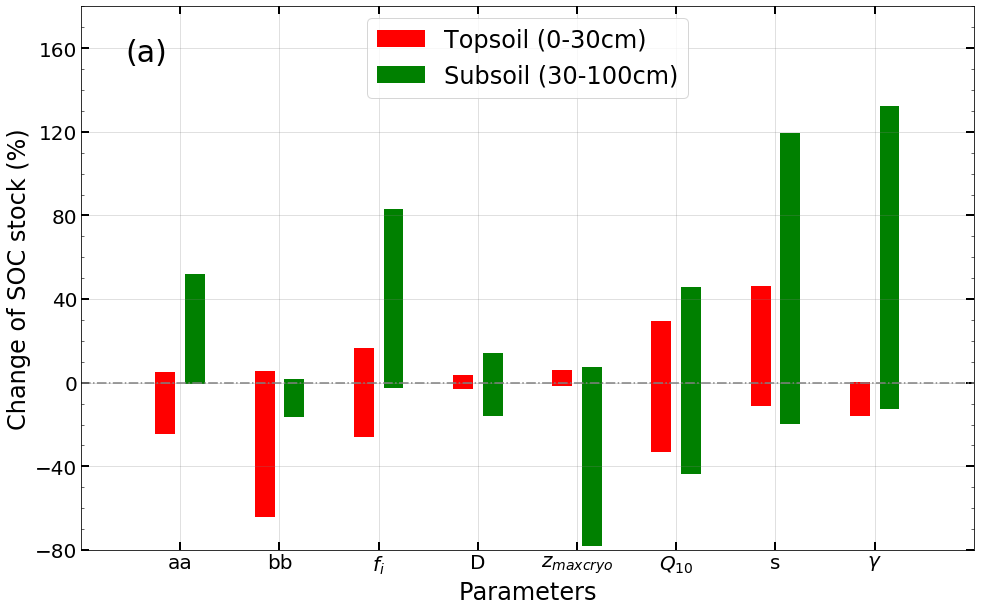

In [30]:
# SOC figure
lower_aa_top = min(mean_aa_soc_minus_top - mean_con_soc_top, mean_aa_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_aa_soc_minus_top - mean_con_soc_top, mean_aa_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
aa_top = abs(lower_aa_top) + abs(temp)

lower_aa_sub = min(mean_aa_soc_minus_sub - mean_con_soc_sub, mean_aa_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_aa_soc_plus_sub - mean_con_soc_sub, mean_aa_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
aa_sub = abs(lower_aa_sub) + abs(temp)

lower_bb_top = min(mean_bb_soc_minus_top - mean_con_soc_top, mean_bb_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_bb_soc_plus_top - mean_con_soc_top, mean_bb_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
bb_top = abs(lower_bb_top) + abs(temp)

lower_bb_sub = min(mean_bb_soc_minus_sub - mean_con_soc_sub, mean_bb_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_bb_soc_plus_sub - mean_con_soc_sub, mean_bb_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
bb_sub = abs(lower_bb_sub) + abs(temp)

lower_bd_top = min(mean_bd_soc_minus_top - mean_con_soc_top, mean_bd_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_bd_soc_plus_top - mean_con_soc_top, mean_bd_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
bd_top = abs(lower_bd_top) + abs(temp)

lower_bd_sub = min(mean_bd_soc_minus_sub - mean_con_soc_sub, mean_bd_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_bd_soc_plus_sub - mean_con_soc_sub, mean_bd_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
bd_sub = abs(lower_bd_sub) + abs(temp)

lower_d_top = min(mean_d_soc_minus_top - mean_con_soc_top, mean_d_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_d_soc_plus_top - mean_con_soc_top, mean_d_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
d_top = abs(lower_d_top) + abs(temp)

lower_d_sub = min(mean_d_soc_minus_sub - mean_con_soc_sub, mean_d_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_d_soc_plus_sub - mean_con_soc_sub, mean_d_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
d_sub = abs(lower_d_sub) + abs(temp)

lower_dep_top = min(mean_dep_soc_minus_top - mean_con_soc_top, mean_dep_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_dep_soc_plus_top - mean_con_soc_top, mean_dep_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
dep_top = abs(lower_dep_top) + abs(temp)

lower_dep_sub = min(mean_dep_soc_minus_sub - mean_con_soc_sub, mean_dep_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_dep_soc_plus_sub - mean_con_soc_sub, mean_dep_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
dep_sub = abs(lower_dep_sub) + abs(temp)

lower_q_top = min(mean_q_soc_minus_top - mean_con_soc_top, mean_q_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_q_soc_plus_top - mean_con_soc_top, mean_q_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
q_top = abs(lower_q_top) + abs(temp)

lower_q_sub = min(mean_q_soc_minus_sub - mean_con_soc_sub, mean_q_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_q_soc_plus_sub - mean_con_soc_sub, mean_q_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
q_sub = abs(lower_q_sub) + abs(temp)

lower_s_top = min(mean_s_soc_minus_top - mean_con_soc_top, mean_s_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_s_soc_plus_top - mean_con_soc_top, mean_s_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
s_top = abs(lower_s_top) + abs(temp)

lower_s_sub = min(mean_s_soc_minus_sub - mean_con_soc_sub, mean_s_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_s_soc_plus_sub - mean_con_soc_sub, mean_s_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
s_sub = abs(lower_s_sub) + abs(temp)

lower_gamma_top = min(mean_gamma_soc_minus_top - mean_con_soc_top, mean_gamma_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_gamma_soc_plus_top - mean_con_soc_top, mean_gamma_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
gamma_top = abs(lower_gamma_top) + abs(temp)

lower_gamma_sub = min(mean_gamma_soc_minus_sub - mean_con_soc_sub, mean_gamma_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_gamma_soc_plus_sub - mean_con_soc_sub, mean_gamma_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
gamma_sub = abs(lower_gamma_sub) + abs(temp)

# Calculated from Testbed
#ncscd_30_m = 11.51
#ncscd_70_m = 13.43
#ncscd_30 = 5.84/ncscd_30_m*100
#ncscd_70 = 9.54/ncscd_70_m*100

blank_top = [lower_aa_top, lower_bb_top, lower_bd_top, lower_d_top, lower_dep_top, lower_q_top, lower_s_top,
             lower_gamma_top]
blank_sub = [lower_aa_sub, lower_bb_sub, lower_bd_sub, lower_d_sub, lower_dep_sub, lower_q_sub, lower_s_sub,
             lower_gamma_sub]
bval_top = [aa_top, bb_top, bd_top, d_top, dep_top, q_top, s_top, gamma_top]
bval_sub = [aa_sub, bb_sub, bd_sub, d_sub, dep_sub, q_sub, s_sub, gamma_sub]
xpos_top = [0.85, 1.85, 2.85, 3.85, 4.85, 5.85, 6.85, 7.85]
xpos_sub = [1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15, 8.15]

plt.figure(figsize=(16,10))
sentopplt = plt.bar(xpos_top, bval_top, width=0.2, bottom=blank_top, align='center', color='r')
sensubplt = plt.bar(xpos_sub, bval_sub, width=0.2, bottom=blank_sub, align='center', color='g')
ind = [1,2,3,4,5,6,7,8]
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, ('aa', 'bb', '$f_i$', 'D', '$z_{maxcryo}$', '$Q_{10}$', 's', '$\gamma$'), fontsize=20)
plt.yticks([-120, -80, -40, 0, 40, 80, 120, 160, 200], fontsize=20)
plt.xlim((0, 9))
plt.ylim((-80, 180))
plt.legend(['Topsoil (0-30cm)', 'Subsoil (30-100cm)'], loc='upper center', fontsize=24)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
#plt.plot(mpos_top, bline_top,'k')
#plt.plot(mpos_sub, bline_sub,'k')
plt.plot([0, 9], [0, 0], 'gray', linestyle='-.')
plt.xlabel('Parameters', fontsize=24)
plt.ylabel('Change of SOC stock (%)', fontsize=24)
plt.annotate('(a)', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=30)

plt.show()
#plt.savefig('./figures/fig4/fig4a.png')

In [37]:
np.asarray(bval_top)+np.asarray(blank_top)

array([ 5.35657213,  5.72853595, 16.49696083,  3.62161824,  6.07445757,
       29.58157751, 46.42237281,  0.35488839])

In [36]:
np.asarray(blank_top)

array([-24.57416973, -64.20281504, -26.15115048,  -3.16692384,
        -1.7728714 , -33.26356143, -11.1685915 , -15.70056929])

In [39]:
np.asarray(bval_sub)+np.asarray(blank_sub)

array([ 52.21821328,   1.75908155,  83.11859002,  14.37196577,
         7.31235601,  45.5619686 , 119.6592635 , 132.49080137])

In [38]:
np.asarray(blank_sub)

array([ -0.74366198, -16.22891833,  -2.30033818, -15.90947428,
       -78.03323769, -43.5036087 , -19.58126636, -12.6211404 ])

In [16]:
outdf_sen['aa_Turnover_plus'][0:5].as_matrix()

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([ 873., 1372.,  826.,  388.,  828.])

In [17]:
outdf_sen['aa_Turnover_minus'][0:5].as_matrix()

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([ 667., 1398.,  615.,  489.,  736.])

In [18]:
outdf_sen['Turnover'][0:5].as_matrix()

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([ 634., 1368.,  607.,  447.,  707.])

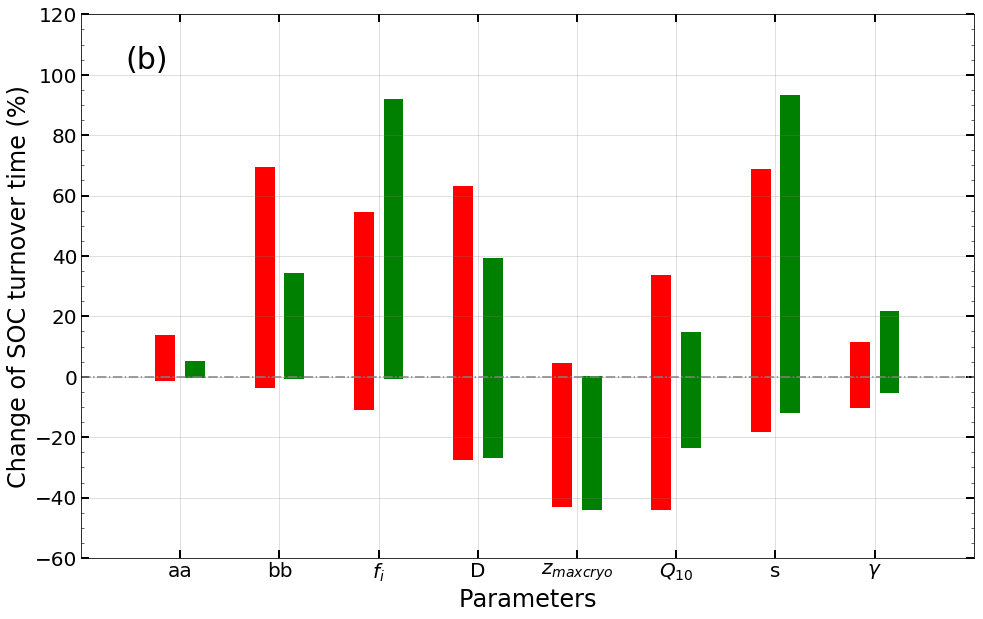

In [40]:
# Turnover figure
# Some of the retreival of STT has some issue
lower_aa_top = (min(mean_aa_tau_minus_top - mean_con_tau_top, mean_aa_tau_plus_top - mean_con_tau_top)-40)/mean_con_tau_top*100
temp = max(mean_aa_tau_minus_top - mean_con_tau_top, mean_aa_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
aa_top = abs(lower_aa_top) + abs(temp)

lower_aa_sub = (min(mean_aa_tau_minus_sub - mean_con_tau_sub, mean_aa_tau_plus_sub - mean_con_tau_sub)-80)/mean_con_tau_sub*100
temp = max(mean_aa_tau_plus_sub - mean_con_tau_sub, mean_aa_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
aa_sub = abs(lower_aa_sub) + abs(temp)

lower_bb_top = (min(mean_bb_tau_minus_top - mean_con_tau_top, mean_bb_tau_plus_top - mean_con_tau_top)-40)/mean_con_tau_top*100
temp = max(mean_bb_tau_plus_top - mean_con_tau_top, mean_bb_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
bb_top = abs(lower_bb_top) + abs(temp)

lower_bb_sub = (min(mean_bb_tau_minus_sub - mean_con_tau_sub, mean_bb_tau_plus_sub - mean_con_tau_sub)-180)/mean_con_tau_sub*100
temp = max(mean_bb_tau_plus_sub - mean_con_tau_sub, mean_bb_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
bb_sub = abs(lower_bb_sub) + abs(temp)

lower_bd_top = min(mean_bd_tau_minus_top - mean_con_tau_top, mean_bd_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_bd_tau_plus_top - mean_con_tau_top, mean_bd_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
bd_top = abs(lower_bd_top) + abs(temp)

lower_bd_sub = min(mean_bd_tau_minus_sub - mean_con_tau_sub, mean_bd_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_bd_tau_plus_sub - mean_con_tau_sub, mean_bd_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
bd_sub = abs(lower_bd_sub) + abs(temp)

lower_d_top = min(mean_d_tau_minus_top - mean_con_tau_top, mean_d_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_d_tau_plus_top - mean_con_tau_top, mean_d_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
d_top = abs(lower_d_top) + abs(temp)

lower_d_sub = min(mean_d_tau_minus_sub - mean_con_tau_sub, mean_d_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_d_tau_plus_sub - mean_con_tau_sub, mean_d_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
d_sub = abs(lower_d_sub) + abs(temp)

lower_dep_top = min(mean_dep_tau_minus_top - mean_con_tau_top, mean_dep_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_dep_tau_plus_top - mean_con_tau_top, mean_dep_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
dep_top = abs(lower_dep_top) + abs(temp)

lower_dep_sub = min(mean_dep_tau_minus_sub - mean_con_tau_sub, mean_dep_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_dep_tau_plus_sub - mean_con_tau_sub, mean_dep_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
dep_sub = abs(lower_dep_sub) + abs(temp)

lower_q_top = min(mean_q_tau_minus_top - mean_con_tau_top, mean_q_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_q_tau_plus_top - mean_con_tau_top, mean_q_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
q_top = abs(lower_q_top) + abs(temp)

lower_q_sub = min(mean_q_tau_minus_sub - mean_con_tau_sub, mean_q_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_q_tau_plus_sub - mean_con_tau_sub, mean_q_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
q_sub = abs(lower_q_sub) + abs(temp)

lower_s_top = min(mean_s_tau_minus_top - mean_con_tau_top, mean_s_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_s_tau_plus_top - mean_con_tau_top, mean_s_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
s_top = abs(lower_s_top) + abs(temp)

lower_s_sub = min(mean_s_tau_minus_sub - mean_con_tau_sub, mean_s_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_s_tau_plus_sub - mean_con_tau_sub, mean_s_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
s_sub = abs(lower_s_sub) + abs(temp)

lower_gamma_top = min(mean_gamma_tau_minus_top - mean_con_tau_top, mean_gamma_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_gamma_tau_plus_top - mean_con_tau_top, mean_gamma_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
gamma_top = abs(lower_gamma_top) + abs(temp)

lower_gamma_sub = min(mean_gamma_tau_minus_sub - mean_con_tau_sub, mean_gamma_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_gamma_tau_plus_sub - mean_con_tau_sub, mean_gamma_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
gamma_sub = abs(lower_gamma_sub) + abs(temp)

blank_top = [lower_aa_top, lower_bb_top, lower_bd_top, lower_d_top, lower_dep_top, lower_q_top, lower_s_top,
             lower_gamma_top]
blank_sub = [lower_aa_sub, lower_bb_sub, lower_bd_sub, lower_d_sub, lower_dep_sub, lower_q_sub, lower_s_sub,
             lower_gamma_sub]
bval_top = [aa_top, bb_top, bd_top, d_top, dep_top, q_top, s_top, gamma_top]
bval_sub = [aa_sub, bb_sub, bd_sub, d_sub, dep_sub, q_sub, s_sub, gamma_sub]
xpos_top = [0.85, 1.85, 2.85, 3.85, 4.85, 5.85, 6.85, 7.85]
xpos_sub = [1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15, 8.15]

plt.figure(figsize=(16,10))
sentopplt = plt.bar(xpos_top, bval_top, width=0.2, bottom=blank_top, align='center', color='r')
sensubplt = plt.bar(xpos_sub, bval_sub, width=0.2, bottom=blank_sub, align='center', color='g')
ind = [1,2,3,4,5,6,7,8]
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, ('aa', 'bb', '$f_i$', 'D', '$z_{maxcryo}$', '$Q_{10}$', 's', '$\gamma$'), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((0, 9))
plt.ylim((-60, 120))
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
plt.plot([0, 9], [0, 0], 'gray', linestyle='-.')
plt.xlabel('Parameters', fontsize=24)
plt.ylabel('Change of SOC turnover time (%)', fontsize=24)
plt.annotate('(b)', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=30)

plt.show()
#plt.savefig('./figures/fig4/fig4b.png')

In [41]:
np.asarray(bval_top)+np.asarray(blank_top)

array([13.92505979, 69.5190008 , 54.53095934, 63.16768536,  4.51767207,
       33.69651874, 68.93436088, 11.50677651])

In [42]:
np.asarray(blank_top)

array([ -1.54132341,  -3.82673399, -11.13473293, -27.50465054,
       -43.15705554, -43.95429179, -18.38958278, -10.17804943])

In [43]:
np.asarray(bval_sub)+np.asarray(blank_sub)

array([ 5.33976742, 34.36436991, 92.08923345, 39.27695594,  0.27687683,
       14.68238272, 93.22047306, 21.86535875])

In [44]:
np.asarray(blank_sub)

array([ -0.27687683,  -0.85436279,  -0.88600585, -26.95198165,
       -44.24491733, -23.52661973, -11.88988213,  -5.37932126])

In [ ]:
mean_d_soc_plus_top = np.nanmean(outdf_sen['d_SOC_plus'][0:5].as_matrix())
std_d_soc_plus_top = np.nanstd(outdf_sen['d_SOC_plus'][0:5].as_matrix())
mean_d_soc_minus_top = np.nanmean(outdf_sen['d_SOC_minus'][0:5].as_matrix())
std_d_soc_minus_top = np.nanstd(outdf_sen['d_SOC_minus'][0:5].as_matrix())

mean_d_soc_plus_sub = np.nanmean(outdf_sen['d_SOC_plus'][5:10].as_matrix())
std_d_soc_plus_sub = np.nanstd(outdf_sen['d_SOC_plus'][5:10].as_matrix())
mean_d_soc_minus_sub = np.nanmean(outdf_sen['d_SOC_minus'][5:10].as_matrix())
std_d_soc_minus_sub = np.nanstd(outdf_sen['d_SOC_minus'][5:10].as_matrix())


In [ ]:
np.asarray(blank_sub)+np.asarray(bval_sub)

In [ ]:
blank_sub

In [ ]:
ncscd_30_m = 11.51
ncscd_70_m = 13.43
ncscd_30 = 5.84/ncscd_30_m*100
ncscd_70 = 9.54/ncscd_70_m*100
print(ncscd_30)
print(ncscd_70)

In [ ]:
np.nanstd(outdf_sen['d_SOC_minus'][0:5].as_matrix())

In [ ]:
mean_con_soc_top

In [ ]:
mean_con_soc_sub

In [ ]:
mean_dep_soc_minus_sub